# Getting started with neural networks

For this assignment, we're going to take a first look at neural networks. Neural networks are a model constructed of a large combination of artificial neurons. We can use logistic regression as the building block for each of these artificial neurons and create a whole network of logistic regression units.

Logistic regression is not the only building block we could use, there are a lot of different types of units and connections used in neural networks. However, logistic regression is the block that was historically used in the first neural networks, and in many ways, it is the most intuitive regression unit to create such a network with. So, for this assignment, we'll build some neural networks using only logistic regression units. In the language of neural networks, we're building a fully connected neural network with sigmoid activations at every layer.

This notion of combining several elemental building blocks or *modules*, in
order to create a more complex network, is at the heart of neural networks. In
fact, many of the recent advances in AI come from *deep* neural networks, which
means they are the result of combining **a lot** of these modules. So, building
the modules in such a way that we can easily stack many of them, will be
essential.

This assignment consists of three parts. In the first part you will learn more about modularity. You will re-implement logistic regression, but now in such a way that it can be used as a module in a neural network. In the second part you will use this logistic regression module to build a neural network. In the last part you will have a look at how you could implement the training of a single logistic regression module. This last part sets you up for the next module in which you will learn how to deal with the training of a complete neural network.

## Part 1: Modularity (Logistic Regression)

The first module we will build, as mentioned, is logistic
regression. You've already programmed this algorithm of course, but we'll
change the implementation to make it better fit with the idea of modularity.
None of these changes will modify the core steps of Logistic
regression, but they will change the way we program and mathematically
represent the algorithm. The 3 main changes will be:

1. Changing the way the bias term $\theta_0$ is added to the inputs. Up to now
we've always added a column of 1's to the inputs, so the bias parameter
could just be handled the same as every other parameter. However, if we stack a
lot of modules together, that solution would become very messy.

2. Viewing every step of the algorithm as part of a computational graph, even
a simple step like adding the bias. This might seem like a strange step at
first, but it will make trying to learn the parameters of all these modules a
lot easier.

3. Implementing the algorithm using *Object Oriented* programming, making it
possible to create several *instances* of the algorithm, which can then easily
be stacked and linked together, creating a large network of these smaller
self-contained modules.

### Logistic Regression, change 1: the bias term 

#### The classical approach

The classical approach to add a bias term in logistic regression is by adding a $1$ to the input $x$ and adding a term $\theta_0$ to the parameter vector $\theta$:

$$
\tilde{x} =
\begin{pmatrix}
1 & x_1 & x_2 & \cdots & x_n
\end{pmatrix}, 
\theta =
\begin{pmatrix}
\theta_0 & \theta_1 & \theta_2 & \cdots & \theta_n
\end{pmatrix}
$$

So to compute the output (hypothesis) $\hat{y}$ you just have to multiply the $\tilde{x}$ and $\theta$ vectors before applying the sigmoid function $g$:

$$
z = \tilde{x} \cdot \theta \\
\hat{y} = g(z) \\
g(z) = \frac{1}{1+e^{-z}}
$$

Working out these equations gives the following result:

$$
\hat{y} = g(\theta_0 + \theta_1 \cdot x_ 1 + \theta_2 \cdot x_1 + \cdots  + \theta_n \cdot x_n)
$$

Where you can see that $\theta_0$ is the bias value.

#### Add the bias explicitly

This approach becomes messy when we take logistic regression to be a module that can be chained to other modules, like we would for neural networks. So instead we're going to explicitly add the bias term:

$$
z = x \cdot \theta + b\\
\hat{y} = g(z)
$$

When you work out these equations you can see that it is mathematically identical to the previous result, with the only difference that the bias term $\theta_0$ is now called $b$:

$$
\hat{y} = g(\theta_1 \cdot x_ 1 + \theta_2 \cdot x_1 + \cdots  + \theta_n \cdot x_n + b)
$$

#### Vectorize with $\oplus$

Although the new representation is mathematically the same as the classic representation, you have to pay attention when vectorizing this. When we want to calculate the output for multiple samples at once, so $X$ is an $m \times n$ matrix ($n$ features, $m$ samples), you would get the equations:

$$
z = X \cdot \theta \color{red} + b\\
\hat{y} = g(z)
$$

Here $X \cdot \theta$ is a vector containing $m$ values, but $b$ is a simple scalar. In linear algebra those *cannot be added*. However numpy has a way around this. It uses a system called broadcasting to apply the addition of $b$ to each of the elements of $X \cdot \theta$. We will use the symbol $\oplus$ to denote numpy style addition. Strictly speaking, this operation is not a part of linear algebra and so you will not find it in any literature, but it is very convenient to use in this context. So, the vectorized equations can now be written as: 

$$
z = X \cdot \theta \oplus b\\
\hat{y} = g(z)
$$

#### Gradient terms

This also changes the gradient. Or we should say gradients. Next to computing the gradient for $\theta$ you have to also compute the gradient for $b$. The gradient for $\theta$ is the same as for the classic approach, but the one for $b$ differs slightly:

$$
\frac{\partial J_{\theta,b}}{\partial \theta_j} = \frac{1}{m}\sum_{i=1}^m (\hat{y}^i - y^i)x_j^i \\
\frac{\partial J_{\theta,b}}{\partial b} = \frac{1}{m}\sum_{i=1}^m (\hat{y}^i - y^i)
$$

The derivation of $\frac{\partial J_{\theta,b}}{\partial b}$ is a bit long for this notebook. But the result shouldn't be too surprising; after all, the bias term in the original solution was computed by setting $x_0$ to $1$, and when you substitute $x_j$ by $1$ in the first equation above, you get the second.

When represented as matrix operations, this comes down to:

$$
\frac{\partial J_{\theta,b}}{\partial \theta} = \frac{1}{m}X^T(\hat{y} -y) \\
\frac{\partial J_{\theta,b}}{\partial b} = \frac{1}{m}\sum_{i=1}^m (\hat{y}^i - y^i)
$$

> Note that the gradient of $b$ isn't reduced any further into linear algebra terms. It is possible to do so, but it isn't very helpful for implementation.

### Logistic Regression, change 2: computational graphs


#### Computational graphs in general

A convenient way to represent the mathematics in neural networks is using computational graphs. It allows you to represent a neural network as data flowing through a network of computation. Especially when we're going to look at backpropagation (i.e. learning), this is particularly useful. We will already start using computational graphs here, to get used to the notation.

The following graph represents the computation $c= a + b$

<img src="src/cg1.svg" width="20%">

The computation $+$ is represented as a node where the data from variables $a$ and $b$ flow into.

So if the values of $a$ and $b$ are $2$ and $1$, respectively the data-flow through the computational graph would look like this:

<img src="src/cg2.svg" width="20%">

Let's have a look at a second, more complex example, $c = ln(ab + 2a^2)$:

<img src="src/cg3.svg" width="40%">

#### Logistic regression as computational graph

Similarly we can represent logistic regression as a computational graph. We adopt the convention to represent the non vectorized version of the equations for the computational graph. So we will assume a single input vector $x$ and a single output value $y$.

The computational graph for logistic regression looks like this:

<img src="src/Logistic Regression.svg" width="40%">

And we represent the gradients by dashed arrows going in the opposite direction:

<img src="src/Logistic Regression gradients.svg" width="40%">

With the relatively low complexity of logistic regression, this representation might not feel very useful yet. But it will start to make more sense once we move on to neural networks.



### Logistic Regression, change 3: implemented as a Python class

#### Gradient descent algorithms

Before we implement logistic regression as a class, it is good to think about its specifications. All gradient descent algorithms (e.g., linear and logistic regression) follow the same pattern: 

- They all predict some output $y$ based on some input $X$ (the _forward_ pass).
- There is some cost function (loss) that allows us to quantify how good our current predictions are.
- They all compute some gradient that tells us how we should change the parameters of the model to give better predictions next time (the _backward_ pass).
- There is some form of gradient descent in which we take a step in the opposite direction of the gradient.

#### Using classes

In the previous modules you implemented these steps for both linear and logistic regression using separate variables and functions. This made running the algorithm and managing the data quite messy. The idea of using a class is that we can bundle all of this together and make running the descent algorithm much cleaner. 

Before we implement the class, let's have a look at how it is *intended to be used*. What we would like is that (once the class is defined) we can create a new logistic regression model and set the initial values of the learning parameters ($\Theta$ and $b$) by simply creating a new instance. For example, if we want to have a logistic model with 4 inputs:

    my_model = Logistic(4)

Then, if we want do a step of the gradient descent algorithm for some input `X` and some given output `y`, we want to be able to do something like this:

    # predict the output for X
    my_model.forward(X)
    
    # compute the gradients
    my_model.backward(y)
    
    # update the learning parameter theta and b, using a learning rate alpha
    my_model.step(alpha)

Note that nowhere above you see any variables representing the learning parameters or the gradients. This is the crucial part: they are encapsulated inside the class. So once the class is defined we don't have to think about them anymore. Those details will be abstracted away by our design. 

The function `optimize()` is the function that will run the gradient descent given the model that you will implement. The function `optimize()` is already implemented a little bit further down. Have a look at it, you will see it implements the logistic algorithm exactly as described here. However, it will not work yet, because the implementation of the class `Logistic` is not finished yet. This is left up to you to finish.

#### Class specification

As we established, all gradient descent algorithms are very similar and so the classes implementing them will all look very similar. We can rely on the previously mentioned commonalities to define a general template for any of those algorithms. We will agree that any class that represents a gradient descent module, will implement the following methods:

- `__init__`, set initial learning parameter.
- `forward`, given some input $x$ predict an output $\hat{y}$.
- `backward`, compute all gradients of the parameters (given the output $\hat{y}$ computed in `forward`, and the target value $y$).
- `step`, update all parameters (based on the gradients computed in `backward`, and a learning rate `alpha`).
- `cost`, compute the cost (given the output $\hat{y}$ computed in `forward`, and the target value $y$).

By observing this template we should be able to apply the gradient descent algorithm to any module by repeatedly calling the methods `forward`, `backward` and `step` in succession, until we reach convergence (whatever our criterion for convergence might be).  

### Assignment 1

Now we're going to re-implement logistic regression as a class. We've made a start with the implementation, but the class `Logistic` below is not completely finished. Your task is to complete the `TODO`'s. Of course, you can re-use some code from the logistic regression assignment from last week, but bear in mind that there are some changes in implementation regarding the bias.

In [1]:
class Logistic():
    def __init__(self, s_in):
        """ Set initial values of parameters. """
        
        # the parameters (updated in step)
        self.theta = np.zeros(s_in)
        self.b = 0
        
        # the input and output values (set in forward)
        self.X = None
        self.y_hat = None
        
        # the gradient values (set in backward)
        self.d_theta = None
        self.d_b = None
  
        
    def forward(self, X):
        """ Compute prediction, y_hat, based on self.theta, self.b and x."""
        
        self.X = X
        
        # z values
        self.z = np.matmul(self.X, self.theta) + self.b
        
        # logistic function
        self.y_hat = 1 / (1 + np.exp(-self.z))
        
        return self.y_hat
        
    def backward(self, y):
        """ Compute gradients self.d_theta and self.d_b, based on self.y_hat and y."""
        
        self.y = y
        
        # set m to length of x
        m = self.X.shape[0]

        # calculate d_theta
        fraction = (1/m)
        error = self.y_hat - y
        sum_error = np.matmul(self.X.T, error)
        self.d_theta = fraction * sum_error
        
        # calculate d_b
        fraction = (1/m)
        sum_error = np.sum(self.y_hat - y)
        self.d_b = fraction * sum_error

        return self.d_theta, self.d_b

    def step(self, alpha = 0.1):
        """ Update self.theta and self.b based on self.d_theta, self.d_b, and alpha."""

        self.theta = self.theta - alpha * self.d_theta
        self.b = self.b - alpha * self.d_b
        
        return self.theta, self.b
        
        
        
    def cost(self, y = None):
        """ Compute cost, based on prediction, self.y_hat, and target: y (or self.y)."""
        if not y:
            y = self.y
            
        # return cost based on:
        # - the predicted output (self.y_hat) 
        # - and the actual values (y or self.y)
        
        # set m to length of x
        m = self.X.shape[0]
    
        # cost = -1 / m * np.sum(y * np.log(X) + (1 - y) * (np.log(1 - X)))
        part1 = np.multiply(y, np.log(self.y_hat))
        part2 = np.multiply((1 - self.y), np.log(1 - self.y_hat))
        summ = np.sum(part1 + part2)
        fraction = - (1 / m)
        cost = (fraction * summ)
        
        return cost
        
        

The function `optimize` below runs the gradient descent algorithm. If you implemented the methods above correctly, this function should work for the `Logistic` class. 

In [2]:
def optimize(model, X, y, alpha, iterations = 500):
    """Apply gradient descent for `iterations` number of steps to any learning model that
       implements the correct functions, i.e. forward(), backward(), step() and cost()."""
    costs = []
    for i in tqdm(range(iterations)):
        # descent

        model.forward(X)
        model.backward(y)
        model.step(alpha)
        
        # keep track of costs
        costs.append(model.cost())
        
        # check for divergence (alpha too big)
        if len(costs) >= 2 and (costs[-2] - costs[-1]) < 0:
            print(f'Diverging at iteration {len(costs)}')
            return costs  
    return costs

def confusion_matrix(p, y):
    return np.vstack((p, 1 - p)) @ np.vstack((y, 1 - y)).T

### Test your solution
Let's start by loading the titanic data again. This time we start with a version of this dataset that we've already cleaned up and is ready to use.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def round_output(x):
    return (x >= 0.5) * 1

data = pd.read_csv('data/clean_titanic.csv', index_col = 0)
y = data['Survived']
X = data.drop('Survived', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3,  random_state=11)

The code below runs the gradient descent and shows the confusion matrix.

If all went well, the confusion matrix should look the same to the one you found in the previous assignment for logistic regression. The values should be close to this:

$$
\begin{matrix}
& y=1 & y=0 \\
\hat{y}=1 & 69 & 21 \\
\hat{y}=0 & 23 & 155
\end{matrix}
$$

In [4]:
# train model and predict
logistic_model = Logistic(X_train.shape[1])
optimize(logistic_model, X_train, y_train, 0.2)
predictions = round_output(logistic_model.forward(X_test))

print('Confusion matrix:')
print(confusion_matrix(predictions, y_test))

100%|██████████| 500/500 [00:01<00:00, 307.20it/s]

Confusion matrix:
[[ 69  21]
 [ 23 155]]


## Part 2: Neural networks

### Logistic layer

As you have learned from Andrew's videos, classic neural networks consist of multiple logistic layers. Each layer is essentially Logistic Regression, but instead of one single output, a logistic layer can have multiple outputs. And those outputs serve as the inputs for the next layer.

#### Intuitive solution

So, let's say we want to create a logistic layer that outputs $o$ values labeled $y_1, y_2, \ldots y_o$. One way you could theoretically accomplish this is by just creating $o$ different logistic regression units with $o$ individual $\theta$ parameters, and $o$ individual $b$ parameters, that all operate on the input $x$, like so:

<img src="src/Mulit Logistic Regression.svg" width="50%">

Where we could create the output by composing all the outputs of the individual units into one vector: 

$$
\hat{y} = \begin{pmatrix} y_1 & y_2 & \cdots & y_o \end{pmatrix}
$$

#### Efficient solution

This makes intuitive sense but it is not particularly elegant, and it will not be very efficient if you would implement it this way. Generally we always try to express everything as much as possible as a single matrix operation. This makes use of the hardware you use for the computation much more efficiently. 

We can rewrite the above graph by creating a single weight matrix combining all the weights $\theta_i$ and a vector $b$ containing all the biases $b_i$:

$$
W = 
\begin{pmatrix} 
-\theta_1 - \\ 
-\theta_2 - \\ 
\vdots \\
-\theta_o -  
\end{pmatrix}
,
b = 
\begin{pmatrix} 
b_1 \\ 
b_2 \\ 
\vdots \\
b_o
\end{pmatrix}
$$

The resulting computational graph:

<img src="src/cg4.svg" width="40%">

In the form of equations:

$$
z = W \cdot x + b\\
\hat{y} = g(z)
$$

Which are essentially the same equations as for logistic regression. But, instead of the vector $\theta$, we have an $o\times n$ weight matrix called $W$ (for an input containing $n$ features and $o$ output values). And the bias $b$ is not a scalar value, but a vector of size $o$.

> You've seen two possible solutions: The composed logistic regression units and the representation as a single mathematical system. Verify for yourself that they are mathematically equivalent!

> Note that Andrew uses slightly different conventions here: He uses the symbol $\Theta$ for the weight matrix. And he doesn't use a separate $b$ vector, but instead relies on the trick of augmenting the input vector with $x_0 = 1$.

### Logistic layer vectorized

We have to pay attention when we want to compute multiple samples at once. When $X$ is an $m \times n$ matrix ($n$ features, $m$ samples) and we want to compute $o$ different outputs, we'll have to compute the matrix $\hat{Y}$, which then will be of dimension $m \times o$, all at once:

$$
\hat{Y} = g(Z)
$$

Here $Z$ will be the input of the Logistic function, so this must be a matrix of those same dimensions $m \times o$ ($o$ outputs, $m$ samples). To compute $Z$ we'll need $b$, the vector containing $o$ bias terms and $W$, which is an $o \times n$ matrix of weights. The main difference with simple Logistic Regression is that you need to transpose the weight matrix in order to keep the dimensions correct for $Z$ in the final output:

$$
Z = X \cdot W^{T} \oplus b
$$

#### Example

So if we have a logistic layer with 2 inputs and 3 outputs, with the following equations:

$$
Z = X \cdot W^{T} \oplus b\\
\hat{Y} = g(Z)
$$

The values are represented by the following matrices (for an input containing $m$ samples):

$$
X = 
\begin{pmatrix}
x_{1,1} & x_{1,2} \\ 
x_{2,1} & x_{2,2} \\ 
\vdots & \vdots \\
x_{m,1} & x_{m,2} \\ 
\end{pmatrix}
,
\hat{Y} = 
\begin{pmatrix}
\hat{y}_{1,1} & \hat{y}_{1,2} & \hat{y}_{1,3} \\ 
\hat{y}_{2,1} & \hat{y}_{2,2} & \hat{y}_{2,3} \\ 
\vdots & \vdots  & \vdots \\
\hat{y}_{m,1} & \hat{y}_{m,2} & \hat{y}_{m,3}
\end{pmatrix}
,
W = 
\begin{pmatrix}
W_{1,1} & W_{1,2} \\ 
W_{2,1} & W_{2,2} \\ 
W_{3,1} & W_{3,2} 
\end{pmatrix}
,
b = 
\begin{pmatrix}
b_{1} & b_{2} & b_{3}
\end{pmatrix}
$$

If you enter those values into the equations, you will get the following output:

$$
\hat{Y} = 
\begin{pmatrix}
g(W_{1,1}x_{1,1} + W_{1,2}x_{1,2} + b_1) & g(W_{2,1}x_{1,1} + W_{2,2}x_{1,2} + b_2) & g(W_{3,1}x_{1,1} + W_{3,2}x_{1,2} + b_3)\\ 
g(W_{1,1}x_{2,1} + W_{1,2}x_{2,2} + b_1) & g(W_{2,1}x_{2,1} + W_{2,2}x_{2,2} + b_2) & g(W_{3,1}x_{2,1} + W_{3,2}x_{2,2} + b_3) \\ 
\vdots & \vdots  & \vdots \\
g(W_{1,1}x_{3,1} + W_{1,2}x_{3,2} + b_1) & g(W_{2,1}x_{3,1} + W_{2,2}x_{3,2} + b_2) & g(W_{3,1}x_{3,1} + W_{3,2}x_{3,2} + b_3)
\end{pmatrix}
$$

Verify this for yourself.

### Assignment 2

Implement the class `LogisticLayer` below. You will only have to implement the `init` and the `forward` method. Note that the `forward` method should be very similar to the one of logistic regression. Following the mathematics outlined above, the forward method should implement the following computational graph:

<img src="src/cg5.svg" width="40%">

The `init` method should set the $W$ and $b$ parameters (`self.W` and `self.b`) as `np.array`'s of the right dimensions, as specified by `s_in` (the input size) and `s_out` (the output size). Both $W$ and $b$ should start out filled with zeros.

In [5]:
class LogisticLayer():
    def __init__(self, s_in, s_out):
        """ Set initial values of parameters. """

        # set W to wshape output * input
        self.W = np.zeros((s_out, s_in))

        # set b to number of features
        self.b = np.zeros(s_out)
 
        
    def manually_set_weights(self, W, b):
        """ Set weights manually. Normally you wouldn't do this, but usefull for exercises. """
        assert self.W.shape == W.shape, "W: wrong shape"
        assert self.b.shape == b.shape, "b: wrong shape"
        
        self.W = W
        self.b = b
        
    def forward(self, X):
        """ Compute prediction, y_hat, based on self.theta, self.b and X."""
       
        self.X = X
        
        # z values
        self.z = np.matmul(self.X, self.W.T) + self.b
        
        # logistic function
        self.y_hat = 1 / (1 + np.exp(-self.z))
        
        return self.y_hat

Test if it works:

In [6]:
# test Logistic Layer
testLL = LogisticLayer(3,2)

# some arbitrary test values
testX = np.array([[-1,  0,  1]])
testY = np.array([[0.26894142, 0.73105858]])

# set weights
testLL.manually_set_weights(np.array([[1, 1, 1], [0, 0, 0]]), np.array([-1, 1]))

np.testing.assert_allclose(testLL.forward(testX), testY)
print("Success!")

Success!


### Representing logic functions

The function above can now produce a network output for any $o$ number of neurons, using a single matrix multiplication, with just those slightly modified Logistic regression functions from before. The only thing needed to produce $o$ outputs is a weight matrix $W$ and bias vector $b$ of the correct dimensions, and then the result should be a hypothesis matrix $\hat{Y}$ with dimensions $m \times o$.

### Assignment 3

In the theory videos, Andrew describes how to encode the boolean *AND* function in neural network weights. This is of course a not very realistic toy example. You wouldn't use neural networks for logic operations, but it can be interesting to look at this example to get a feel for how neural networks work. 

Recreate Andrew's example using the `LogisticLayer` class to build a really simple network called `andLL`, with 2 inputs and 1 output (i.e. just basic logistic regression). Andrew's example assumes that the bias is part of the $\Theta$ matrix, whereas we split that up into a separate weight matrix ($W$) and bias vector ($b$). So your solution will look a bit different from the one Andrew proposes.

- Make sure $W$ is a matrix of the correct shape and has the correct values for each of the required $W_{ji}$.
- Make sure the $b$ is a vector of the correct size.
- The network output should be a *column* vector of 4 outputs, corresponding to the logical *AND* of each of the 4 inputs.

In [7]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
andY = np.array([[0], [0], [0], [1]])

'''
These numbers are chosen to get teh right output. 
For the output, it is important that the weights are some positive number, less than the negative number of the bias. 
'''

# Implement the class LogisticLayer
andLL = LogisticLayer(2, 1)

# set weights to 10 and bias to 15
andLL.manually_set_weights(np.array([[10, 10]]), np.array([-15]))

print(round_output(andLL.forward(X)))

[[0]
 [0]
 [0]
 [1]]


Test it:

In [8]:
np.testing.assert_array_equal(round_output(andLL.forward(X)), andY)
print("Success!")

Success!


### Assignment 4

In the same spirit we can encode some other logical operations. Encode the logical operations *OR* and *NAND* below with neural networks `orLL` and `nandLL` respectively. If you're not sure of their definitions, the expected output is provided.

Hint: Think how the input corresponds to the output and work your way back. For which output do you need $z$ to be (very) high, and for which output do you need $z$ to be very low. How does this correspond to the input? How can you manipulate $W$ and $b$ to achieve this?

In [9]:
orY = np.array([[0], [1], [1], [1]])
nandY = np.array([[1], [1], [1], [0]])

'''
This part of the programme encodes the logical operations for OR and NAND with orLL and nandLL respectively
These numbers are chosen to get teh right output. 
'''

# Implement the class LogisticLayer
orLL = LogisticLayer(2, 1)

# Set weights to 10 and bias to 15. Discussed by Andrew Ng (videos) so I used his weights and the bias.
orLL.manually_set_weights(np.array([[20, 20]]), np.array([-10]))

print(round_output(orLL.forward(X)))

# Implement the class LogisticLayer
nandLL = LogisticLayer(2, 1)

# Set weights to 10 and bias to 15 - important to pick some negative weights which are smaller that the bias.
nandLL.manually_set_weights(np.array([[-10, -10]]), np.array([15]))

print(round_output(nandLL.forward(X)))


[[0]
 [1]
 [1]
 [1]]
[[1]
 [1]
 [1]
 [0]]


In [10]:
np.testing.assert_array_equal(round_output(orLL.forward(X)), orY)
np.testing.assert_array_equal(round_output(nandLL.forward(X)), nandY)
print("Success!")

Success!


### Assignment 5

Of course, a logistic layer can have more than one output. Create a new logistic layer called `nand_orLL` that has two outputs, corresponding the *NAND* and *OR* values for every input respectively.

In [11]:
nand_orY = np.array([[0, 1], [1, 1], [1, 1], [1, 0]])

# Implement the class LogisticLayer
nand_orLL = LogisticLayer(2, 2)

# set weights to 10 and bias to 15. Discussed by Andrew Ng (videos) so his used those weights and the bias.
nand_orLL.manually_set_weights(np.array([[20, 20], [-15, -15]]), np.array([-10, 15]))

print(round_output(nand_orLL.forward(X)))

[[0 1]
 [1 1]
 [1 1]
 [1 0]]


Test it:

In [12]:
np.testing.assert_array_equal(round_output(nand_orLL.forward(X)), nand_orY)
print("Success!")

Success!


### Assignment 6

Last one: Try to make a network that models the exclusive or (XOR). If you can't get it to work, explain why.

In [13]:
xorY = np.array([[0], [1], [1], [0]])

# See answer to question below

# print(round_output(xorLL.forward(X)))

**Q1. If you can't get XOR to work, explain why you think this is below.**

*XNOR would require a non-linear decision boundary so this cannot be done with our programme as is. You'd need another layer.*

### Multi-layer neural networks

For some problems, you need to add a *hidden* layer to the neural network. This is where the real expressive power of neural networks lies; combining layers of the network to represent *non-linear* features and solve complex, non-linear functions.

A neural network with 2 layers can already learn *many* more functions than a single layer network. In general, you can stack $n$ different layers together and the basic principle does not change: The output matrix for one layer becomes the input matrix for the next layer, repeated for as many layers as there are in the network.

#### Computational graph

The computational graph for a 2 layer network looks as follows:

<img src="src/Multi layer NN.svg" width="70%">

In general, the computational graph for a single layer looks like this:

<img src="src/Single layer NN.svg" width="35%">

#### The math

Written as equations:
$$
Z_{i} = A_i \cdot W_{i}^T \oplus b \\
A_{i+1} = g(Z_{i})
$$

Where the input of layer $i$ is $A_i$ and the output is $A_{i+1}$. For the first layer ($i = 0$) the input is our data $A_{0} = X$. For the last layer (in the example above $i = 1$) the output is the value we're predicting $A_{2} = \hat{Y}$.

#### Implementation

We can now create a new class called `NN` containing a multilayer neural network. Every layer is a `LogisticLayer` object. The `NN` class follows the same template as `LogisticLayer` did, and so in principle this class should also be implementing all the relevant methods (`__init__`, `forward`, `backward`, `step`, and `cost`). However, for now we will limit ourselves to only the `__init__` and `forward` method.

### Assignment 7

The `NN` class is partially implemented. It contains an `init` method that, given a list with layer dimensions, will create a list with matching `LogisticLayer`objects.

Your goal is to add a `forward` method to this class. It should not require you to write any new mathematical code. You should be able to rely on the `forward` of the logistic layers in `self.layers`.

In [14]:
class NN():
    def __init__(self, layer_sizes = [2,2,1]):
        """ Set initial layers. """
        self.layers = []
        for s_in, s_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.layers.append(LogisticLayer(s_in, s_out))
            
    def manually_set_weights(self, Ws, bs):
        """ Provide list of weight matrices Ws and list of bias vectors bs. Normally you wouldn't do this, but usefull for exercises. """
        assert len(Ws)==len(self.layers), "Ws: wrong length"
        assert len(bs)==len(self.layers), "bs: wrong length"
        
        for layer, W, b in zip(self.layers, Ws, bs):
            layer.manually_set_weights(W, b)
        
    def forward(self, X):
        """ 
        Funtion compute prediction, y_hat, using forward function. It overwrites every self.y_hat.
        To enable use in different layers. Function returns final prediction.
        """

        # set prediction to X to start
        self.y_hat = X

        # add a forward method to the class based on the logistic layers in self.layers, overwrite every self.y_hat
        for layer in self.layers:
            self.y_hat = layer.forward(self.y_hat)
        
        return self.y_hat

Let's see if it works:

In [15]:
testNN = NN(layer_sizes = (3,2,2))

# layer 0: 3(+1) -> 2
testNN.manually_set_weights([np.array([[0.5, 1.0, 1.5], [-0.5, -1.0, -1.5]]), 
                             np.array([[1, 0], [0.5, 0.5]])],
                            [np.array([-1, 1]),
                             np.array([0, 1])])

# output
result = testNN.forward(np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]))
answer = np.array([[0.56683301, 0.81757448],
                   [0.65077768, 0.81757448],
                   [0.62245933, 0.81757448],
                   [0.69372123, 0.81757448],
                   [0.59327981, 0.81757448],
                   [0.67503753, 0.81757448],
                   [0.65077768, 0.81757448],
                   [0.70698737, 0.81757448]])

np.testing.assert_allclose(result, answer)
print("Success!")

Success!


### Assignment 8

Andrew Ng also discusses in detail how to encode the solution for the *XNOR* problem in neural network weights. The network should have 2 inputs, 2 hidden nodes and 1 output, and the necessary added bias nodes for the input and hidden layer.

The same is true for the *XOR* network. Define a neural network called `xorNN` that produces the correct *XOR* output.

> Hint: you can represent a *XOR* b as a combination of other logic ports: (a *NAND* b) *AND* (a *OR* b).

In [16]:
xorY = np.array([[0], [1], [1], [0]])

# build empty network with appropriate inputs, hidden nodes, and outputs
xorNN = NN(layer_sizes = [2, 2, 1])

# set weight and biases for NAND, OR, and AND respectively
xorNN.manually_set_weights([np.array([[-10, -10], [20, 20]]), 
                             np.array([[10, 10]])],
                            [np.array([15, -10]),
                             np.array([-15])])
                            




Test it:

In [17]:
np.testing.assert_array_equal(round_output(xorNN.forward(X)), xorY)
print("Success!")

Success!


### Classifying handwritten digits

This principle is at the *core* of neural networks; adding layers together can solve *much* more complicated problems than just using one layer. For the last part of this assignment, we'll try this algorithm on something a little more interesting than boolean functions, digit recognition.

The data for this problem can be found in the file `digits123.csv`. Each row contains 65 values, where the first 64 are grayscale pixel values, and the last value is the class label, corresponding to the digit being shown. The grayscale values are integers ranging from 1 to 16, and using some reshaping, can be reconstructed back into a low-resolution *8x8* image.

Below is the code to show the image for one digit, i.e. the input for one sample in the data set. Run the code to see the image. Currently, this is the sample at index 200 in the data set, but you can also change this index to display different samples.

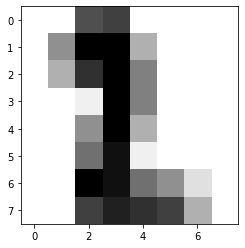

The label for this digit was: 2


In [18]:
digits = np.loadtxt('data/digits123.csv', delimiter=',', dtype=int)

def display_digit(i, digits):
    digit_sample = np.ones((8,8))*16 - np.reshape(digits[i, :-1], (8, 8))
    plt.imshow(digit_sample, cmap='gray', vmax=16)
    plt.show()
    print("The label for this digit was:", digits[i, -1])

display_digit(200, digits)

#### Digit recognition solution

Recognizing these very low-resolution digits, based on the individual pixel values, is probably not a task with a simple linear decision boundary. However, it is actually solvable with just one hidden layer!

Learning the weights of a multi-layer neural network is also done using gradient descent, it is just that computing the correct partial derivatives for *all* the parameters is a lot more tricky. The algorithm to do this is called *backpropagation* and is something we will look at next module.

For this assignment, you're just provided with the already learned weight matrices for this digit recognition problem. Running the code below will load the included matrix files and create a complete 2 layer network in `digitNN`. The network has 64 inputs, 65 hidden nodes, and 3 outputs, with each output corresponding to one of the 3 possible digits; 1, 2 and 3.

For this last step, you will need to compute the accuracy of this network in predicting the digits in this data set. The network output will be a $542 \times 3$ matrix, where the first column indicates the probability that sample was a $1$, the second column the probability the sample was a $2$ and the last column the probability that sample was a $3$. Ultimately, the model should classify each sample as whichever digit was *most likely*.

### Assignment 9

Implement the function `compute_accuracy`, which takes a matrix of network outputs `Y_hat` and a one-hot encoded set of class labels `Y`, and returns the percentage of samples that was classified correctly by the network.

*Hint:* The function [np.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) will save you a lot of work when applied correctly to this problem.

In [19]:
 # Normalize the values of the pixels to be between 0 and 1
X = digits[:, :-1] / 16

# Generate one-hot encoding for Y
y = digits[:, -1]
Y = np.eye(y.max())[y - y.min()]

# Load the already backpropagated weights for the network
digitNN = NN((64, 65, 3))
L0 = np.load('data/digits_theta_1.npy')
L1 = np.load('data/digits_theta_2.npy')
digitNN.layers[0].b = L0[:,0]
digitNN.layers[0].W = L0[:,1:]
digitNN.layers[1].b = L1[:,0]
digitNN.layers[1].W = L1[:,1:]

def compute_accuracy(Y_hat, Y):
    '''
    This function takes as input two matrixes, prediction (with hypothesis values) and y (with ground-truth values)
    The for loop counts the number of predictions in which both matrices have the same output.
    similar output is established using the np.argmax.
    '''
    
    # get the indices of the maximum values along the axis.
    vector_Y_hat = np.argmax(Y_hat, axis = 1)
    vector_Y = np.argmax(Y, axis = 1)
    
    # set counter to calculate accuracy
    counter_correct = 0
    counter_total = 0
    
    # loop over and compare vectors
    for i in range(len(vector_Y_hat)):
        counter_total += 1
        if vector_Y_hat[i] == vector_Y[i]:
            counter_correct += 1
    
    # calculate accuracy
    accuracy = counter_correct / counter_total * 100
    
    return accuracy
    
# Compute the network outputs for the digits
digit_outputs = digitNN.forward(X)

print("\nThe network accuracy for these digits was:")
print(compute_accuracy(digit_outputs, Y))


The network accuracy for these digits was:
99.63099630996311


## Part 3: Learning

Next week we're going to learn how you can train neural networks in general. But let's glance into the future and look at how we can train **a single** logistic layer. For single layer neural networks, learning the parameters, $W$ and $b$, is very similar to learning $\theta$ with logistic regression.

The single layer network takes a vector of inputs for a sample and produces a vector of predictions (instead of just one prediction per sample, as with logistic regression). This vector of predictions corresponds with multi-class classification, with each output learning a separate *one-vs-all* classifier; one classifier to recognize each of the classes that needs to be distinguished. This means that learning the parameters for the whole neural network will, in the case of a *single layer*, just correspond learning several logistic regression outputs "next to each other".

#### As a computational graph

Just as with logistic regression, we use'll the cross entropy loss $l$. However, since the output of the logistic layer is a vector of predictions, the equation for the cost will also have to change accordingly.  To determine the combined cost for all these one-vs-all classifiers, you can just sum the individual cost for each of the outputs together, and compute the total cost that way.

At every training step we would like to calculate how much every weight in $W$ and $b$ should change to decrease this total loss. For this we need to compute the gradients $\frac{\partial l}{\partial W}$ and $\frac{\partial l}{\partial b}$. In the computational graph below we added these gradients:

<img src="src/Multi layer NN back.svg" width="39%">

#### The math

Again, since the output of the logistic layer is not a single value, but a vector, the equations for the gradients are also slightly different to those of logistic regression. If you work out the math, you will see that the difference boils down to doing an extra summation over the outputs. The details are for next week. For now, we will just provide you with the resulting equations:

$$
\frac{\partial J_{W,b}}{\partial W} = \frac{1}{m}(\hat{Y} - Y)^T \cdot X \\
\frac{\partial J_{W,b}}{\partial b} = \frac{1}{m}\sum_{i=1}^m (\hat{Y} - Y)^{\mathrm{row} = i}
$$

where $\frac{\partial J_{W,b}}{\partial b}$ is simply the sum of all the rows of the $m \times o$ matrix $\hat{Y} - Y$.

You can verify for yourself that this is congruent with logistic regression by taking the output dimension $o = 1$ (i.e., you can take $Y$ and $\hat{Y}$ to be vectors of size $m$ instead of $m \times o$ matrices). If you work out the math for yourself, you will see that the above equations become identical to those of logistic regression.

### Assignment 10

Use the formulas above to define the `LogisticLayer` class here below. The `init` is already given, you can copy the `forward` method from above, and you'll have to add the missing methods `backward`, `step`, and `cost`.

Note that all these functions, so `forward`, `backward`, `step`, and `cost`, should work in exactly the same way as they do for the `Logistic` class from *Assignment 1*, except that they should implement these operations for the entire layer of outputs, instead of a single node. Specifically, each function should be implemented in such a way that they can be used by *same* `optimize` function from earlier, also used for the `Logistic` class, with only the model instance changing. 

So, most of these functions will need to store some intermediate results in the object instance, which can then be used by later function calls. For example, the `backward` function should store the passed `Y` matrix, making it possible to later compute the `cost` for that same `Y`, without needing to provide it as an argument. Take a good look at what arguments the functions from the `Logistic` class exactly take, and which attributes they store, and use that as a starting point for your `LogisticLayer` implementation.

The implementation of `backward` only has to work for a single layer, for which the gradient equations are given above. You can reuse the code from logistic regression from earlier, but care should be taken in the vectorization. Since the there are now $o$ different outputs, the vectorized version will produce an $m \times o$ matrix of predictions $\hat{Y}$, which means ($\hat{Y} - Y$) in the gradient computation is now also an $m \times o$ matrix, instead of just a vector of size $m$. As a result, you'll need to make some changes in your implementation to keep all of the vectorized dimensions correct.

> Note that the `init` method randomizes the $W$ and $b$ parameters. The reason for this will be discussed next week.

In [20]:
import numpy as np

class LogisticLayer():
    def __init__(self, s_in, s_out):
        """ set initial weights """
        
        np.random.seed(42)
        self.W = np.random.randn(s_out, s_in)
        self.b = np.random.randn(s_out)

    def forward(self, X):
        """ Compute prediction, y_hat, based on self.W, self.b and x."""
        
        self.X = X
        
        # z values
        self.z = np.matmul(self.X, self.W.T) + self.b

        # logistic function
        self.Y_hat = 1 / (1 + np.exp(-self.z))
        
        return self.Y_hat
    
        
    def backward(self, Y):
        """ Compute gradients self.d_W and self.d_b, based on self.y_hat and y."""
        
        self.Y = Y
        
        # set m to length of x
        m = self.X.shape[0]

        # calculate d_W
        fraction = (1/m)
        error = self.Y_hat - self.Y
        error = np.matmul(error.T, self.X)
        self.d_W = fraction * error
        
        # calculate d_b
        fraction = (1/m)
        sum_error = self.Y_hat - self.Y
        self.d_b = fraction * sum_error

        return self.d_W, self.d_b

    def step(self, alpha = 0.1):
        """ Update self.W and self.b based on self.d_W, self.d_b, and alpha."""
        
        self.W = self.W - alpha * self.d_W
        self.b = self.b - alpha * self.d_b
        
        return self.W, self.b
        
        
        
    def cost(self, Y = None):
        """ Compute cost, based on prediction, self.y_hat, and target: y (or self.y)."""
        
        if not Y:
            Y = self.Y
            
        # return cost based on:
        # - the predicted output (self.y_hat) 
        # - and the actual values (y or self.y)
        # YOUR CODE HERE
        
        # set m to length of x
        m = self.X.shape[0]
        
        # cost = -1 / m * np.sum(y * np.log(X) + (1 - y) * (np.log(1 - X)))
        part1 = np.multiply(Y, np.log(self.Y_hat))
        part2 = np.multiply((1 - self.Y), np.log(1 - self.Y_hat))
        summ = np.sum(part1 + part2)
        fraction = - (1 / m)
        cost = (fraction * summ)
        
        return cost
        
        

The test below optimizes the network using the function defined in the beginning of this notebook. If you defined the `LogisticLayer` correctly, it should learn the correct weights for the *AND* output.

In [21]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
andY = np.array([[0], [0], [0], [1]])

testLL = LogisticLayer(2, 1)
optimize(testLL, X, andY, 0.1, iterations = 1000)
predictions = round_output(testLL.forward(X))
print(predictions)

np.testing.assert_array_equal(predictions, andY)
print("Success!")

100%|██████████| 1000/1000 [00:00<00:00, 13312.25it/s]

[[0]
 [0]
 [0]
 [1]]
Success!


### Assignment 11

Use the logistic layer to learn the correct weights for the *OR* output below:

In [22]:
# similar to andLL, but now we work with the functions and classes for orLL
orLL = LogisticLayer(2, 1)
optimize(orLL, X, orY, 0.1, iterations = 1000)
predictions = round_output(orLL.forward(X))
print(predictions)

np.testing.assert_array_equal(predictions, orY)
print("Success!")
print(predictions)

100%|██████████| 1000/1000 [00:00<00:00, 14529.10it/s]

[[0]
 [1]
 [1]
 [1]]
Success!
[[0]
 [1]
 [1]
 [1]]


In [23]:
np.testing.assert_array_equal(predictions, np.array([[0], [1], [1], [1]]))
print("Success!")

Success!
